In [5]:
from dotenv import load_dotenv

load_dotenv()

DATA_DIR = "../data/social"

# Add parent directory to path so we can import from 'vectorstores
import sys
sys.path.append("..")

def data_file(name: str) -> str: return f"{DATA_DIR}/{name}.json"

In [ ]:
df = load_data()

In [6]:
from vectorstores.keywords import KeywordVectorstore
openai_embeddings = KeywordVectorstore()

In [1]:
import json
import numpy as np
import pandas as pd 
from functools import reduce

import torch  
import torch.nn.functional as F
from numpy.linalg import norm

from transformers import BertTokenizer,BertModel
from transformers import AutoModelForSequenceClassification, AutoTokenizer

## Experiment 1: Does segmenting the input post result in better embeddings? 

In [172]:
def post_query_term(row: pd.Series, segment=False):
    if segment: 
        return f"Author Name: {row['author_name']}. Post Description: {row['description']}. Author Description: {row['author_signature']}."
    return f"{row['author_name']} - {row['description']} - {row['author_signature']}"

In [173]:
search_terms_default = df.apply(post_query_term, axis=1).tolist()
search_terms_segmented = df.apply(post_query_term, args={"segment":True}, axis=1).tolist()

In [179]:
# returns oai keywords for post, oai keywords for segmented post, intersection between the two
def compare_segmented_input(idx):

    post, segmented_post = search_terms_default[idx], search_terms_segmented[idx]
    post_keywords, segmented_post_keywords = openai_embeddings.get_keywords([post, segmented_post])
    post_keywords, segmented_post_keywords = set([p[0] for p in post_keywords]), set([p[0] for p in segmented_post_keywords])
    return post_keywords, segmented_post_keywords, post_keywords.intersection(segmented_post_keywords)


#calculate the average overlap between keywords for normal post and segmented post. 
def test_compare_segmented_input(num_cases):
    overlaps = []
    for idx in range(num_cases): 
        _,_, overlap = compare_segmented_input(idx)
        overlaps.append(len(overlap))
    return np.mean(overlaps)

# test_compare_segmented_input(20)

2.55

### Conclusion 
* over 20 cases, an average of 2.6/3 keywords found for segmented post are also found for non segmented post.  
* segmenting the posts does not lead to different classification results.

## Experiment 2: Does BERT provide comparable embeddings? 

In [180]:
class BertEmbeddings: 
    def __init__(self) -> None:
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') 
        self.model = BertModel.from_pretrained("bert-base-uncased")
        self.vs = self.build_vector_store()
    
    def embed(self, s, normalize_embedding = False, return_list = True):
        inputs = self.tokenizer(s, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad(): 
            output = self.model(**inputs)
        pool_embedding, last_hidden = output.pooler_output, output.last_hidden_state

        if return_list: 
            pool_embedding = pool_embedding.squeeze(0).tolist()
            # if normalize_embedding: 
            #     pool_embedding = self.normalize(pool_embedding)
    
        return pool_embedding

    def build_vector_store(self, as_df = True):
        # Creating embeddings for all keywords in the keywords list.

        with open('../data/personas.json', 'r') as file: 
            personas = json.load(file)

        personas = reduce(lambda l1, l2: l1 + l2, personas.values())
        vs = {i: {'text': v, 'embedding': self.embed(v)} for i, v in enumerate(personas)}
        
        if as_df: 
            vs = pd.DataFrame.from_dict(vs, orient='index')

        return vs 
    
    def search_vector_store(self, sentence, k = 5):
        sent_embedding = self.embed(sentence)
        sent_embedding_normalized = norm(sent_embedding)
        vs = self.vs 
        vs["score"] = vs.embedding.apply(lambda x: np.dot(sent_embedding,x)/(sent_embedding_normalized*norm(x)))
  
        vs.sort_values(by="score", ascending=False, inplace=True)
        top_keywords = [
            (row["text"], row["score"])
            for index, row in vs[["text", "score"]].head(k).iterrows()
        ]
        return top_keywords


In [181]:
bert_embeddings = BertEmbeddings()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0.0

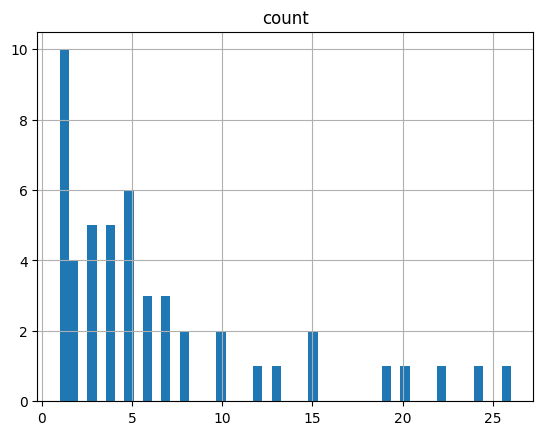

In [185]:
# compare openai embeddings with bert embeddings
def compare_oai_bert(post): 
    oai = openai_embeddings.get_keywords([post])[0]
    bert = bert_embeddings.search_vector_store(post)
    oai = set([pred[0] for pred in oai])
    bert = set([pred[0] for pred in bert])

    return oai, bert, oai.intersection(bert) 

def test_compare_oai_bert(num_cases):
    overlaps = []
    for idx in range(num_cases): 
        _, _, overlap = compare_oai_bert(search_terms_default[idx])
        overlaps.append(len(overlap))
    return np.mean(overlaps)

# test_compare_oai_bert(10)

### Conclusion 
* On average, 0 of 3 classes found by openAI embeddings are found by BERT embeddings. 
* The openAI embeddings out perform BERT embeddings, based on anecdotal comparisons of resultant classifications. 

## Experiment 3: Does HuggingFace multi-label classification work out of the box, or does it require fine-tuning? 


In [186]:
class BertClassifier: 
    def __init__(self) -> None:
        bert_ckpt = "distilbert-base-uncased" 
        self.keywords = self.get_keywords()

        self.tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            bert_ckpt,
            num_labels=len(self.keywords)  ,
            problem_type="multi_label_classification",  
        )
        self.model.config.id2label =  self.keywords

    def get_keywords(self):
        with open('../data/keywords.json', 'r') as file:
            keywords = json.load(file)
        keywords = reduce(lambda l1, l2: l1 + l2, keywords.values())
        keywords = {i: v for i, v in enumerate(keywords)}
        return keywords 
    
    def finetune(self, data):
        # TODO: fine tune the classifier with some data 
        pass 
    
    def classify(self, sequence, threshold=0.53):
        inputs = self.tokenizer(sequence, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            logits = self.model(**inputs).logits
        probabilities = F.sigmoid(logits)

        label_indices = (probabilities > threshold).nonzero(as_tuple=True)[1]
        assigned_labels = [label_indices[i].item() for i in range(len(label_indices))]
        label_ids = [self.model.config.id2label[idx] for idx in assigned_labels]

        return probabilities, label_ids 

In [187]:
bert_classifier = BertClassifier()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.

In [188]:
def evaluate_methods(post):
    bert_probabilities, bert_categories = bert_classifier.classify(post)
    relevant_keywords = '' #vs.get_keywords([post])

    print()
    print(f'''Input Post:\n<START> \n{post} \n<END>, 
Method 1) OpenAI embedding similarity: {relevant_keywords}, 
Method 2) BERT multihead classification: {bert_categories}, 
          BERT classification scores: {bert_probabilities}, 
          
          ''')
# evaluate_methods(search_terms_default[0])
# evaluate_methods(search_terms_default[1])



Input Post:
<START> 
onzpo - Replying to @patrick_sea567 Nah, that's CAP. It's like I always say, I #onzpo use #vfx to make it look like I'm using a #noeyefilter but no #ihaveeyes check the  #lore lol - I'm glad you're still around!
Smash Follow!🕹️
Business:chris@clickstalent.com 
<END>, 
Method 1) OpenAI embedding similarity: , 
Method 2) BERT multihead classification: ['Artisanal', 'Live Music', 'Exploration', 'Fitness Challenge'], 
          BERT classification scores: tensor([[0.5277, 0.5781, 0.4931, 0.5230, 0.5258, 0.4869, 0.4891, 0.5119, 0.4926,
         0.4927, 0.5279, 0.4953, 0.4789, 0.4848, 0.5216, 0.4852, 0.4677, 0.4983,
         0.5171, 0.5283, 0.5042, 0.5502, 0.5119, 0.4958, 0.4993, 0.4931, 0.5232,
         0.5018, 0.4678, 0.5101, 0.5196, 0.4828, 0.4945, 0.4950, 0.4952, 0.5045,
         0.4810, 0.4678, 0.5083, 0.4845, 0.5541, 0.4929, 0.5120, 0.4562, 0.4727,
         0.5134, 0.4990, 0.5245, 0.4586, 0.4996, 0.5507, 0.5054, 0.5133, 0.4752,
         0.4887, 0.4950, 0.5140, 0.4

### Conclusion 
* The classifier requires fine-tuning, since it does not automatically embed the input classes. 

## Experiment 4: Does fine-tuning HF multilabel classifier result in better classifications? 

In [11]:
from torch.utils.data import Dataset, DataLoader

In [3]:
df = pd.read_csv('../data/social/labeled_captions_gpt.csv')
keywords = list(df.columns[1:])

In [72]:
bert_ckpt = "distilbert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(bert_ckpt, use_fast = True)
model = AutoModelForSequenceClassification.from_pretrained(
    bert_ckpt,
    num_labels=len(keywords)  ,
    problem_type="multi_label_classification",  
)
model.config.id2label =  keywords

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.we

In [62]:
class PostDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = df.loc[index]
        caption, classes = row[0], torch.tensor([row[1:]], dtype=torch.float32)
        item =tokenizer(caption, padding=True, truncation=True, max_length=512, return_tensors="pt")
        item['labels']  = classes
        return item 

In [147]:
def collate_fn(batch):
    # TODO: implement batching 
    pass 


ds = PostDataset(df)

In [76]:
from transformers import AdamW, get_linear_schedule_with_warmup
epochs = 7

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(ds)*epochs)
def train():
    for i in range(epochs):
        model.train()
        loss_train_total = 0
        for i in range(len(ds)):
            
            model.zero_grad()
            inputs = ds[i]
            outputs = model(**inputs)
            loss = outputs[0]
            loss_train_total += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()
        print('Mean loss: ', loss_train_total/len(ds))
train() 
        

Mean loss:  0.5207712499300639
Mean loss:  0.4536612930893898
Mean loss:  0.37426499197880425
Mean loss:  0.29873875026901564
Mean loss:  0.24966790671149888
Mean loss:  0.22045469112694263
Mean loss:  0.20574019826948642


In [158]:
from datetime import datetime 
def save_model_state_dict(model, use_datetime = False, model_state_dict_id = None ):
    if model_state_dict_id: 
        pass 
    elif use_datetime:
        now = datetime.now()
        model_state_dict_id = str(now).replace(" ", "")
    else:
        return 
    
    torch.save(model.state_dict(), f'../model_state_dicts/bert-ft-{model_state_dict_id}.model')

def load_model_state_dict(model, model_state_dict_id):
    model.load_state_dict(torch.load(f'../model_state_dicts/bert-ft-{model_state_dict_id}.model', map_location=torch.device('cpu')))



In [153]:
save_model_state_dict(model, model_state_dict_id= '1')
load_model_state_dict(model, model_state_dict_id='1')

In [111]:
def compute_accuracy(predicted, actual):
    correct = (predicted == actual).sum().item()
    accuracy = correct / actual.size(0)
    return accuracy

# returns 1.0 if the top k classes in the prediction match the k True classes in the input. 
def compute_example_based_accuracy(y_pred, y_actual):
    k = torch.sum(y_actual == 1)  # number of classes assigned in the label
    pred_classes, actual_classes = torch.topk(y_pred, k=k).indices, torch.where(y_actual == 1)[0]
    return compute_accuracy(pred_classes, actual_classes) 

def evaluate(): 
    accuracies = []
    for i in range(len(ds)):
        with torch.no_grad():
            inputs = ds[i]
            outputs = model(**inputs) 

            y_predicted, y_actual = outputs.logits.squeeze(0), inputs['labels'].squeeze(0)
            accuracy = compute_example_based_accuracy(y_predicted, y_actual)
            accuracies.append(accuracy)

    print("Mean accuracy:", np.mean(accuracies))

evaluate()

Mean accuracy: 0.775


In [145]:
# get top k predicted classes on input string 
def predict(input, k):
    with torch.no_grad():
        input =tokenizer(input, padding=True, truncation=True, max_length=512, return_tensors="pt")
        output = model(**input)
        pred_logits = output.logits.squeeze(0)
        pred_label_ids = torch.topk(pred_logits, k).indices
        pred_labels = [keywords[i] for i in pred_label_ids]
        return pred_labels

# prints models predictions on a list of strings 
def predict_for_test_dataset(test_data, k=3):
    for t in test_data: 
        print(f"Post: {t}\nClasses: {predict(t, k)}")
        print('\n')


In [183]:
test_examples_3 = ["Raw shrimp for thanksgiving #gaydolphin", "nyc psychic ruined my life", "i didn't fall but i won't be ice skating again.", "i fell but i will be ice skating again."]
predict_for_test_dataset(c, k =4)

Post: Raw shrimp for thanksgiving #gaydolphin
Classes: ['culinaryExplorer', 'familyOrientedIndividual', 'socialButterfly', 'wellnessSelfCareAdvocate']


Post: nyc psychic ruined my life
Classes: ['artCultureEnthusiast', 'adventurerExplorer', 'socialButterfly', 'ecoConsciousConsumer']


Post: i didn't fall but i won't be ice skating again.
Classes: ['artCultureEnthusiast', 'adventurerExplorer', 'wellnessSelfCareAdvocate', 'socialButterfly']


Post: i fell but i will be ice skating again.
Classes: ['adventurerExplorer', 'wellnessSelfCareAdvocate', 'artCultureEnthusiast', 'ecoConsciousConsumer']




In [186]:
test_examples_1 = ["I love the outdoors!", 
                 "Danced all night with KP, then total girls night in talkin till mornin ", 
                 "My London, madenessss ", 
                 "One of the best UNICEF ambassadors",
                 "Taking my power back.. can't wait to show you where I've been. I love y'all. Ps, I still obsess over pickles. " ]

predict_for_test_dataset(test_examples_1)


Post: I love the outdoors!
Classes: ['ecoConsciousConsumer', 'adventurerExplorer', 'familyOrientedIndividual']


Post: Danced all night with KP, then total girls night in talkin till mornin 
Classes: ['socialButterfly', 'wellnessSelfCareAdvocate', 'artCultureEnthusiast']


Post: My London, madenessss 
Classes: ['beautyFashionAficionado', 'artCultureEnthusiast', 'socialButterfly']


Post: One of the best UNICEF ambassadors
Classes: ['beautyFashionAficionado', 'ecoConsciousConsumer', 'artCultureEnthusiast']


Post: Taking my power back.. can't wait to show you where I've been. I love y'all. Ps, I still obsess over pickles. 
Classes: ['socialButterfly', 'wellnessSelfCareAdvocate', 'artCultureEnthusiast']




In [187]:
test_examples_2 = ["Happy birthday brother. I can't wait to go to spain and go hiking in the alps.", "Happy birthday brother. I can't wait to go to spain and eat food." ]

predict_for_test_dataset(test_examples_2, k=4)


Post: Happy birthday brother. I can't wait to go to spain and go hiking in the alps.
Classes: ['familyOrientedIndividual', 'adventurerExplorer', 'wellnessSelfCareAdvocate', 'socialButterfly']


Post: Happy birthday brother. I can't wait to go to spain and eat food.
Classes: ['culinaryExplorer', 'familyOrientedIndividual', 'socialButterfly', 'wellnessSelfCareAdvocate']




In [188]:
test_examples_3 = ["Raw shrimp for thanksgiving #gaydolphin", "nyc psychic ruined my life", "i didn't fall but i won't be ice skating again.", "i fell but i will be ice skating again."]
predict_for_test_dataset(test_examples_2, k=4)


Post: Happy birthday brother. I can't wait to go to spain and go hiking in the alps.
Classes: ['familyOrientedIndividual', 'adventurerExplorer', 'wellnessSelfCareAdvocate', 'socialButterfly']


Post: Happy birthday brother. I can't wait to go to spain and eat food.
Classes: ['culinaryExplorer', 'familyOrientedIndividual', 'socialButterfly', 'adventurerExplorer']




In [ ]:
class BertClassifier: 
    def __init__(self) -> None:
        bert_ckpt = "distilbert-base-uncased" 
        self.keywords = self.get_keywords()

        self.tokenizer = AutoTokenizer.from_pretrained(bert_ckpt)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            bert_ckpt,
            num_labels=len(self.keywords)  ,
            problem_type="multi_label_classification",  
        )
        self.model.config.id2label =  self.keywords

    def get_keywords(self):
        with open('../data/keywords.json', 'r') as file:
            keywords = json.load(file)
        keywords = reduce(lambda l1, l2: l1 + l2, keywords.values())
        keywords = {i: v for i, v in enumerate(keywords)}
        return keywords 
    
    def finetune(self, data):
        # TODO: fine tune the classifier with some data 
        pass 
    
    def classify(self, sequence, threshold=0.53):
        inputs = self.tokenizer(sequence, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            logits = self.model(**inputs).logits
        probabilities = F.sigmoid(logits)

        label_indices = (probabilities > threshold).nonzero(as_tuple=True)[1]
        assigned_labels = [label_indices[i].item() for i in range(len(label_indices))]
        label_ids = [self.model.config.id2label[idx] for idx in assigned_labels]

        return probabilities, label_ids 